# Vehicle Detection
To detect vehicles in images we will perform the following steps:
    1. HOG detection
    2. Color feature extraction
    3. Data preparation
    4. Classifier training
    5. Sliding window implementation
    6. Search and Classify
    7. Multiple Detection and reduce false positives
    8. Creating a pipeline to detect objects in a movie 

## HOG Detection
To perform Histogram Orientation Detection (HOG) we have multiple parameters to pick. First we have to choose the colorspace. We found in literature that YCrCb is a popular color space. This is described in [Creusen et al., 2010](https://pure.tue.nl/ws/files/3283178/Metis245392.pdf) where the authors describe that the best traffic sign detection are found by means of the CIELab and YCrCb color space. In [Baghel et al., 2017](http://www.ijcaonline.org/archives/volume134/number7/23927-2016907926) the authors have success removing shadow using YCrCb color space. As such we are interested in creating a HOG feature map for the Cb and the Cr channgels. Since the Y channel in YCrCb encodes a grayscale image we will use that image for our HOG detection.

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog

In [2]:
%matplotlib inline

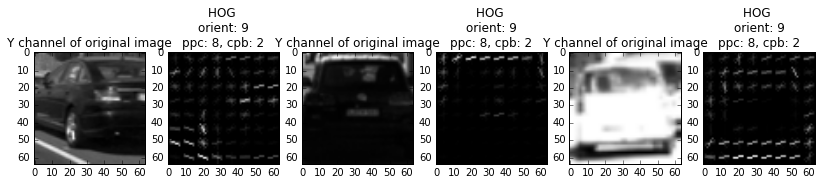

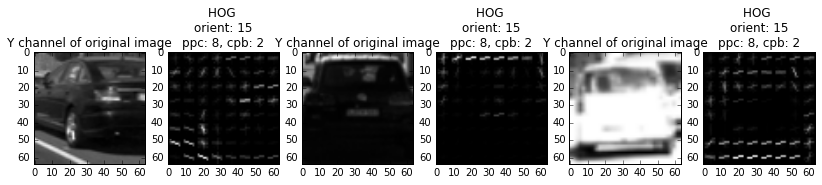

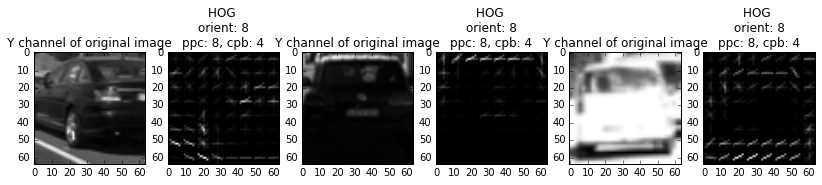

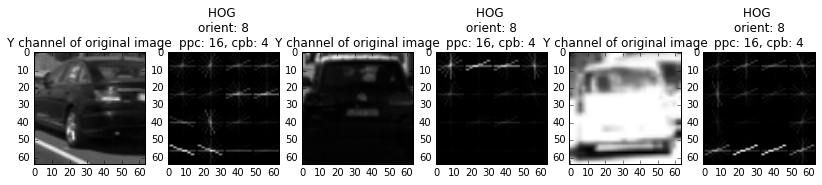

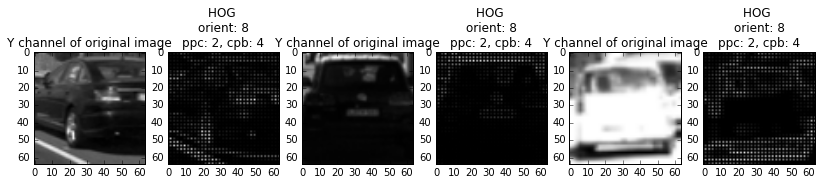

In [3]:
   
def plot_hog_sample(images, orient, pix_per_cell, cell_per_block):
    num_img = len(images) * 20
    img_idx = 1
    fig = plt.figure(figsize=(14,6))
    for image_name in images:
        # Read the image and convert it to YCrCb color space
        img = cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2YCR_CB)
        img_Y = img[:,:,0]
        img_Y = img_Y.astype(np.float64)
        feature, hog_image = hog(img_Y, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        plt.subplot(100 + num_img + img_idx)
        img_idx += 1
        plt.title('Y channel of original image')
        plt.imshow(img_Y, cmap='gray')
        plt.subplot(100 + num_img + img_idx)
        img_idx += 1
        plt.imshow(hog_image, cmap='gray')
        plt.title('HOG \norient: %s\nppc: %s, cpb: %s' %
                 (orient, pix_per_cell, cell_per_block))

test_images = ['./vehicles/GTI_Right/image0003.png', './vehicles/KITTI_extracted/108.png',
               './vehicles/KITTI_extracted/249.png']
plot_hog_sample(test_images, 9, 8, 2)
# Let us increase the orientation bins. The drawback of having more orientation bins is that the 
# classifier will need to learn more features.
plot_hog_sample(test_images, 15, 8, 2)
# Let us decrease the orientation bins to 8 and increase the cell per block
plot_hog_sample(test_images, 8, 8, 4)
# Let us also increase the pixels per cell
plot_hog_sample(test_images, 8, 16, 4)
# Let us decrease the pixels per cell
plot_hog_sample(test_images, 8, 2, 4)

We see from altering the parameters that our initial parameters were actually quite good. As described in [Ballesteros et al., 2014](http://www.eurasip.org/Proceedings/Eusipco/Eusipco2014/HTML/papers/1569924423.pdf) the optimal number of cell blocks for SVM classifier depends on whether an object is at the right, center or left and near or far. We see that 8 orientation bins is optimal with 4 cells per block size 2. We see from the last row of images that this leads to a large grid which may complicate the computation at a later stage. For now we will however continue with these value.

## Color Feature Extraction
We used HOG on the Y channel of the YCrCb encoding. We will encode the Cr and Cb channels with a histogram and perform normalization.

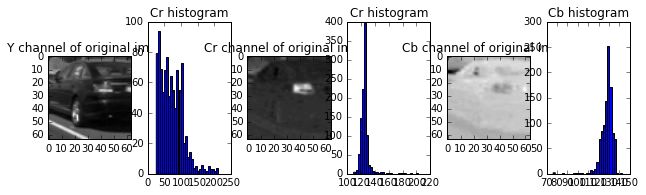

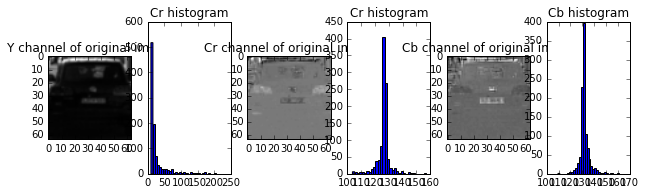

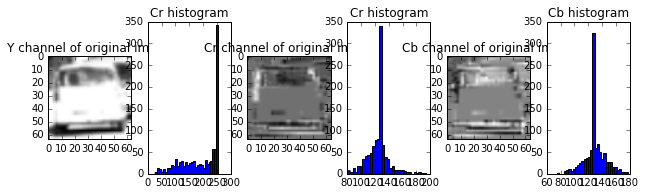

In [4]:
def histograms(img, size = 32):
    features = cv2.resize(img, (size, size)).ravel()
    return features
   
def plot_hist_sample(images):
    num_img = len(images) * 60
    for image_name in images:
        # Read the image and convert it to YCrCb color space
        fig = plt.figure(figsize=(14,6))
        img = cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2YCR_CB)
        img_Y = img[:,:,0].astype(np.float64)
        feature = histograms(img_Y)
        img_idx = 1
        plt.subplot(100 + num_img + img_idx)
        plt.title('Y channel of original image')
        plt.imshow(img_Y, cmap='gray')
        img_idx += 1
        plt.subplot(100 + num_img + img_idx)
        plt.hist(feature, 32)
        plt.title('Cr histogram')
        img_Cr = img[:,:,1].astype(np.float64)
        feature = histograms(img_Cr)
        img_idx += 1
        plt.subplot(100 + num_img + img_idx)
        plt.title('Cr channel of original image')
        plt.imshow(img_Cr, cmap='gray')
        img_idx += 1
        plt.subplot(100 + num_img + img_idx)
        plt.hist(feature, 32)
        plt.title('Cr histogram')
        img_Cb = img[:,:,2].astype(np.float64)
        feature = histograms(img_Cb)
        img_idx += 1
        plt.subplot(100 + num_img + img_idx)
        plt.title('Cb channel of original image')
        plt.imshow(img_Cb, cmap='gray')
        img_idx += 1
        plt.subplot(100 + num_img + img_idx)
        plt.hist(feature, 32)
        plt.title('Cb histogram')
        
plot_hist_sample(test_images)

We see that we get interesting peaks in the histograms and that even standardized they cannot be substituted. This is particularly clear in the first figure. The histogram of the Cr channel is skewed to the left whereas the Cb channel is skewed to the left. We will therefore use all three.

## Combining Features
Next we combine the features that we extracted above. We first compute all the features and scale the entire concatenated feature vector at once. We will see however that this leads to outliers showing up and all HOG features to dissappear. In our second attempt we standardize the YCrCb features and the HOG features separately. This leads to more variation.

In [5]:
def color_hist(img, nbins=32, bins_range=(0,256)):
    Y_channel = np.histogram(img[:,:,0], bins=nbins, range=bins_range, density=True)
    Cr_channel = np.histogram(img[:,:,1], bins=nbins, range=bins_range, density=True)
    Cb_channel = np.histogram(img[:,:,2], bins=nbins, range=bins_range, density=True)
    hist_feature = np.concatenate((Y_channel[0], Cr_channel[0], Cb_channel[0]))
    return hist_feature

def hog_features(img, orient=8, pix_per_cell=8, cell_per_block=2):
    features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                   visualise=False)
    return features
 

def extract_features(img, size=32):
    img = cv2.resize(img, (size, size))
    hog_feat = hog_features(img[:,:,0])
    color_feat = color_hist(img)
    all_features = np.concatenate((hog_feat, color_feat))
    return all_features

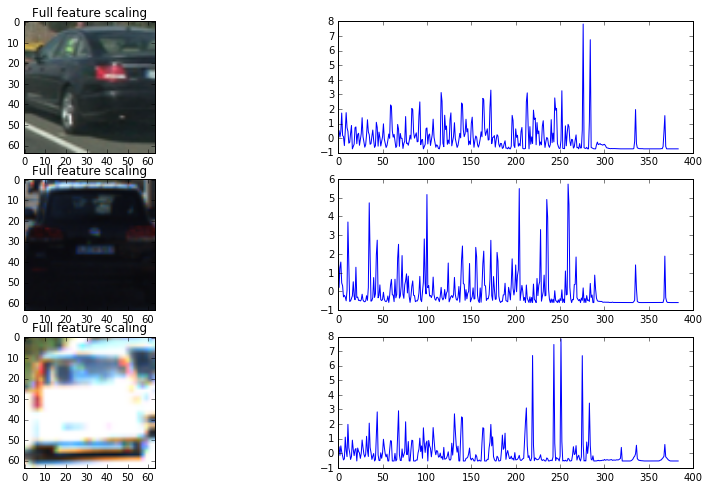

In [6]:
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler

def plot_features_norm_all(images):
    fig = plt.figure(figsize=(14,8))
    gs = gridspec.GridSpec(len(images),2)
    for i, image_name in enumerate(images):
        # Read the image and convert it to YCrCb color space
        img = cv2.imread(image_name)
        img_conv = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
        ax = plt.subplot(gs[i * 2])
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        features = extract_features(img_conv)
        features = features.reshape(-1, 1).astype(np.float64)
        scaler = StandardScaler().fit(features)
        scaled_features = scaler.transform(features)
        plt.title('Full feature scaling')
        ax = plt.subplot(gs[i * 2 + 1])
        ax.plot(scaled_features)
   
    return None
       
plot_features_norm_all(test_images)

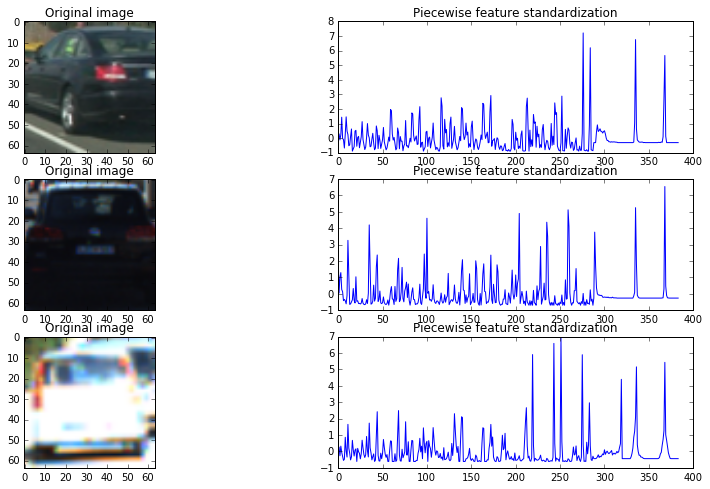

In [8]:
def extract_features_norm_pc(img, size=32):
    img = cv2.resize(img, (size, size))
    hog_feat = hog_features(img[:,:,0]).reshape(-1,1).astype(np.float64)
    hog_feat_sclr = StandardScaler().fit(hog_feat)
    hog_feat_sc = hog_feat_sclr.transform(hog_feat)
    color_feat = color_hist(img).reshape(-1,1).astype(np.float64)
    color_feat_sclr = StandardScaler().fit(color_feat) 
    color_feat_sc = color_feat_sclr.transform(color_feat)
    all_features = np.concatenate((hog_feat_sc, color_feat_sc))
    return all_features

def plot_features_norm_pc(images):
    fig = plt.figure(figsize=(14,8))
    gs = gridspec.GridSpec(len(images),2)
    for i, image_name in enumerate(images):
        # Read the image and convert it to YCrCb color space
        img = cv2.imread(image_name)
        img_conv = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
        img_idx = 1
        ax = plt.subplot(gs[i * 2])
        plt.title('Original image')
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        features = extract_features_norm_pc(img_conv)
        ax = plt.subplot(gs[i * 2 + 1])
        plt.title('Piecewise feature standardization')
        ax.plot(features)
        
    return None
       
plot_features_norm_pc(test_images)

We see that piecewise scaling yields the HOG features, which are more on the left part of the graph, as well as the YCrCb features, which are more on the right, to show up in equal amounts.

In [7]:
import glob

car_features = []
noncar_features = []

for img_fn in glob.iglob('vehicles/**/*png'):
    img = cv2.cvtColor(cv2.imread(img_fn), cv2.COLOR_BGR2YCR_CB)
    car_features.append(extract_features(img))

for img_fn in glob.iglob('non-vehicles/**/*png'):
    img = cv2.cvtColor(cv2.imread(img_fn), cv2.COLOR_BGR2YCR_CB)
    noncar_features.append(extract_features(img))

## Inspect Training Size
Let us first inspect the amount of training data that we have. This should be equal to ensure that the model will not only learn the features associated with one category.

In [8]:
print("Size of car features: %s" % len(car_features))
print("Size of non car features: %s" % len(noncar_features))

Size of car features: 8792
Size of non car features: 8968


We have a bit more non car features. Since we care more about cars we will drop at random some non car images to ensure that both have the same dimension.

In [9]:
# Create training labels
noncar_features = np.stack(noncar_features[:len(car_features)])
car_features = np.stack(car_features)

print(noncar_features.shape)
print(car_features.shape)

(8792, 384)
(8792, 384)


In [10]:
N = 200
x = np.append(car_features[:N], noncar_features[:N], axis=0)
scaler = StandardScaler().fit(x)
X_scaled = scaler.transform(x)
print(X_scaled.shape)

(400, 384)


In [11]:
y = np.hstack((np.ones(car_features[:N].shape[0]), np.zeros(noncar_features[:N].shape[0])))
print(y.shape)

(400,)


## SVM Classifier
We can run the SVM classifier now. In the SVM fit there is a hyperparamater $C$. This hyperparameter penalizes the misclasification and margin errors as explained [here](http://pyml.sourceforge.net/doc/howto.pdf), which occur when a data point is classified in the wrong category. We seek to do a grid search over $C$ to find the value that most accuractely predicts the category to which an image belongs. We will use a $k$ fold cross validation in combination with the grid search.

In [ ]:
from sklearn.svm import SVC
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, SparsePCA

pipe = Pipeline([
    ('reduce_dim', PCA()),
    ('classify', SVC())
])

N_FEATURES_OPTIONS = [10, 50, int(X_scaled.shape[1] * .25), int(X_scaled.shape[1] * .5)]
print(N_FEATURES_OPTIONS)
# Define the range over which the grid should search, currently at 5 can be increased.
param_grid = {
    'reduce_dim': [PCA(iterated_power=7), SparsePCA()],
    'reduce_dim__n_components': N_FEATURES_OPTIONS,
    'classify__C': [1e3, 5e3, 1e4, 5e4, 1e5],
    'classify__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv, verbose=2, n_jobs=4, 
                    pre_dispatch='n_jobs', 
                    scoring=metrics.make_scorer(metrics.scorer.f1_score, average="binary"))
clf = grid.fit(X_scaled, y)

[10, 50, 96, 192]
Fitting 3 folds for each of 240 candidates, totalling 720 fits


In [19]:
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'classify__gamma': 0.005, 'reduce_dim__n_components': 96, 'classify__C': 1000.0, 'reduce_dim': PCA(copy=True, iterated_power=7, n_components=96, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)} with a score of 1.00


## Locating Object in Frame
We extracted three frames in which we will locate cars. This will also allow us to work on the algorithm that will recognize objects in a movie. First we use the `slide_window()`, `draw_box()` and `search_windows()` functions from the course. We adjust these to match our steps described above.

In [ ]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler):
    """Search in windows in the image whether the classifier can predict 1.
    
    params:
    img      an image in RGB color space
    windows  a list of windows that should be searched
    clf      a classifier that predicts 1 or 0
    scaler   a scaler to transform the features"""
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (32, 32))      
        #4) Extract features for that window using single_img_features()
        features = extract_features(test_img)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [ ]:
import time
tic = time.perf_counter()
fig = plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(len(images),1)
for i, img_nm in enumerate(glob('*jpg')):
    img = plt.imread(img_nm)
    windows = slide_windows(img)
    pos_windows = search_windows(img, windows, scaler, )
    img_clf = draw_boxes(img, pos_windows)
    ax = plt.subplot(gs[i])
    plt.imshow(img_clf)
    
toc = time.perf_counter()
print("Time taken: %s" % (tic - toc))
    